<h1 style="font-size:2.0rem; color:green;"> Trends and climatological averages using ESA CCI data, ESA CCI gap-filled data, LMDZ-ORCHIDEE_35km data, ERA_LAND_9km data scf_ERA5_25km data, and scf_HighResMIP_Atlas_1950_2014 data  </h1>  

<h1 style="font-size:1.5rem; color:green;"> Load required libraries </h1> 

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2  

import numpy as np
import pandas as pd
import netCDF4 as nc
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy     
from cartopy.feature import NaturalEarthFeature
import cartopy.crs as ccrs 
import cartopy.feature as cf
from cartopy.util import add_cyclic_point
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

<h1 style="font-size:1.5rem; color:green;"> For parallelisation  </h1> 

In [2]:
from dask.distributed import Client
client = Client(n_workers=16, threads_per_worker=2, memory_limit='32GB')
client

C:\Users\Hamid\anaconda3\lib\site-packages\distributed\node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 58455 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:58456' processes=16 threads=32, memory=476.84 GiB>

<h1 style="font-size:1.5rem; color:green;"> Initialization of the variables  </h1> 

In [19]:
period = slice('1982-01-01', '2014-12-31')
mons= [1,2,3,4,11,12]
wet_months_labels = ["JAN","FEB","MAR","APR","NOV","DEC"]
dry_months_labels = ["MAY","JUN","JUL","AUG","SEP","OCT"]
months_labels = {'wet':wet_months_labels,'dry':dry_months_labels}

output_path = r'C:\Users\Hamid\Desktop\results\figures\climatologies\monthly_average_small_domaine'              
path_model_data = r'C:\Data\Snow\SCFG\Models\LMDZ-ORCHIDEE\Modified_data\monthly_values_threshold_0'
path_esa_data = r'C:\Data\Snow\SCFG\Satellite\modified_data\monthly_values_threshold_0'
path_era5 = r'C:\Data\Snow\SCFG\Reanalysis\ERA5\modified_data\monthly_values'

path_era_land = r'C:\Data\Snow\SCFG\Reanalysis\ERA-LAND\monthly_values_threshold_0'
output_path_figures = r'C:\Users\Hamid\Desktop\results\figures\spatio-temporal_analysis\basic_climatology\means\monthly_average_threshold_0_with_ERA5'
parameters = ["scf_monthly_value", "scf_monthly_value_15","days_with_snow", "days_with_snow_15", "ext_days_with_snow", "ext_days_with_snow_15"]
suptitles = {"scf_monthly_value":"scf monthly value", "scf_monthly_value_15":'scf monthly value with the constraint 15 days missing days',"days_with_snow":'days with snow', "days_with_snow_15":'days with snow with the constraint 15 days missing days', "ext_days_with_snow":'extrapolated days with snow', "ext_days_with_snow_15":' extrapolated days with snow with snow with the constraint 15 days missing days'}
mon_days = {'wet':[31,28,31,30,30,31],'dry':[31,30,31,31,30,31]}
months = {'wet':[1,2,3,4,11,12],'dry':[5,6,7,8,9,10]}
leg_title = 'Snow cover fraction in %'
scf_max_leg = 60
scf_min_leg = 0

<h1 style="font-size:1.5rem; color:green;"> Importing and preparing data</h1>

In [5]:
scf_monthly_values_esa_orig = xr.open_dataset(path_esa_data +r'\ESA_CCI_ORIG_variables_monthly_values.nc').sel(time=period).load()
scf_monthly_values_esa_gf = xr.open_dataset(path_esa_data +r'\ESA_CCI_GF_variables_monthly_values.nc').sel(time=period).load()

scf_monthly_values_lmdz_saloua_35km = xr.open_dataset(path_model_data +r'\scf_lmdz_variables_monthly_values.nc').sel(time=period).load()
scf_monthly_values_era5 = xr.open_dataset(path_era5 +r'\scf_ERA5_1959_2022_variables_monthly_values_threshold_0.nc').sel(time=period).load()
scf_monthly_values_high_res_mip_50km = xr.open_dataset(path_model_data +r'\scf_HighResMIP_Atlas_1950_2014_variables_monthly_values.nc').sel(time=period).load()
scf_era_land_9km = xr.open_dataset(path_era_land +r'\scf_ERA_Land_1950_2022_variables_monthly_values.nc').sel(time=period).load()

<div class="alert alert-block alert-success"; background-color:red> We put the datasets in a dictionary, each dataset with a key </div> 

In [6]:
keys_dic = ["ESA_ORIG","ESA_GF","ERA_LAND", "SIM_35k","ERA5","SIM_50km"]
monthly_values = {"ESA_ORIG":scf_monthly_values_esa_orig,"ESA_GF":scf_monthly_values_esa_gf,"ERA_LAND": scf_era_land_9km, "SIM_35k":scf_monthly_values_lmdz_saloua_35km,"ERA5":scf_monthly_values_era5,"SIM_50km":scf_monthly_values_high_res_mip_50km}

<div class="alert alert-block alert-success"; background-color:red> There are 5 missing dates in the time dimension of the
    data scf_monthly_values_esa_orig, we will add these dates and assign them nan values </div> 

In [7]:
"""
We detect missing dates by applying the difference function between a complete dataset and the dataset that is not
complete  
"""
missing_dates = set(monthly_values['ESA_GF'].time.values).difference(set(monthly_values['ESA_ORIG'].time.values))
missing_dates = list(missing_dates)   

# Then we convert the list of missing date to warray dataarray 
missing_date_ds = xr.DataArray(missing_dates, dims=["time"], coords=[missing_dates])

# We constract a dataaray of the whole dates period  
full_dates = xr.concat([scf_monthly_values_esa_orig.time, missing_date_ds], dim="time")

# We reindex the original dataset and fill empty values with nan
scf_monthly_values_esa_orig = scf_monthly_values_esa_orig.reindex(time=full_dates, fill_value=np.nan).sortby("time")

<h1 style="font-size:1.5rem; color:green;"> The monthly climatological averages without any constraint </h1>

In [8]:
# We define a dictionnary that will contain the five datasets of monthly averages of all above-mentioned variables 
monthly_values_basic_mean = {key:'a' for key in keys_dic}

In [9]:
# We compute the averages off all variables for all datasets 
for key in keys_dic:   
    monthly_values_basic_mean[key] = monthly_values[key].groupby('time.month').mean(dim='time')

In [ ]:
# We store the results      
#for key in keys_dic:
#    monthly_values_basic_mean[key].to_netcdf(output_path + '/based_monthly_averages/'+key+'_based_average.nc')                               

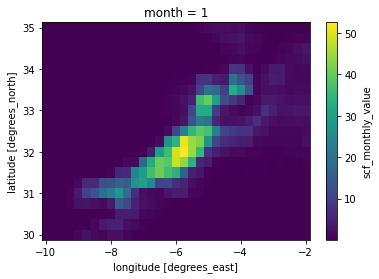

In [11]:
# Checking data 
monthly_values_basic_mean['ERA5'].loc[{'month':1}]['scf_monthly_value'].plot()

<div class="alert alert-block alert-success"; background-color:red> We define the formatting function of the figures </div> 

In [12]:
# This auxiliary function will help us in the formatting of the figures
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

<div class="alert alert-block alert-success"; background-color:red> We personalize the colorbar </div> 

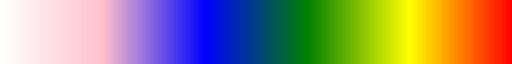

In [13]:
import matplotlib as mpl
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

c0='white'
c1='pink' 
c2='blue' 
c3='green' 
c4='yellow' 
c5='red' 

n=250

colors0 = []
colors1 = []
colors2 = []
colors3 = []
colors4 = []
for x in range(n+1):
    colors0.append(colorFader(c0,c1,x/n))
    colors1.append(colorFader(c1,c2,x/n))
    colors2.append(colorFader(c2,c3,x/n))
    colors3.append(colorFader(c3,c4,x/n))
    colors4.append(colorFader(c4,c5,x/n))

colors = colors0 + colors1 + colors2 + colors3 + colors4

cmap_init = mpl.colors.ListedColormap(colors)
cmap_init

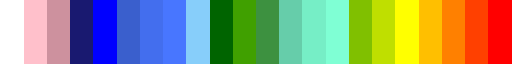

In [14]:
colors = ['white','#FFC0CB','#CD919E', '#191970', '#0000FF', '#3A5FCD', '#436EEE', '#4876FF', '#87CEFA',
         'darkgreen', '#40a000', '#3D9140', '#66CDAA', '#76EEC6', '#7FFFD4','#80c000', '#bfdf00', '#ffff00',
         '#ffbf00', '#ff8000', '#ff4000', '#ff0000']
cmap_scatter = mpl.colors.ListedColormap(colors)
cmap_scatter  

In [ ]:
keys_dic

In [16]:
keys_dic=['SIM_50km', 'SIM_35k','ERA5', 'ERA_LAND', 'ESA_ORIG', 'ESA_GF']

<h1 style="font-size:1.5rem; color:green;"> scf_monthly_value plot for wet months </h1>

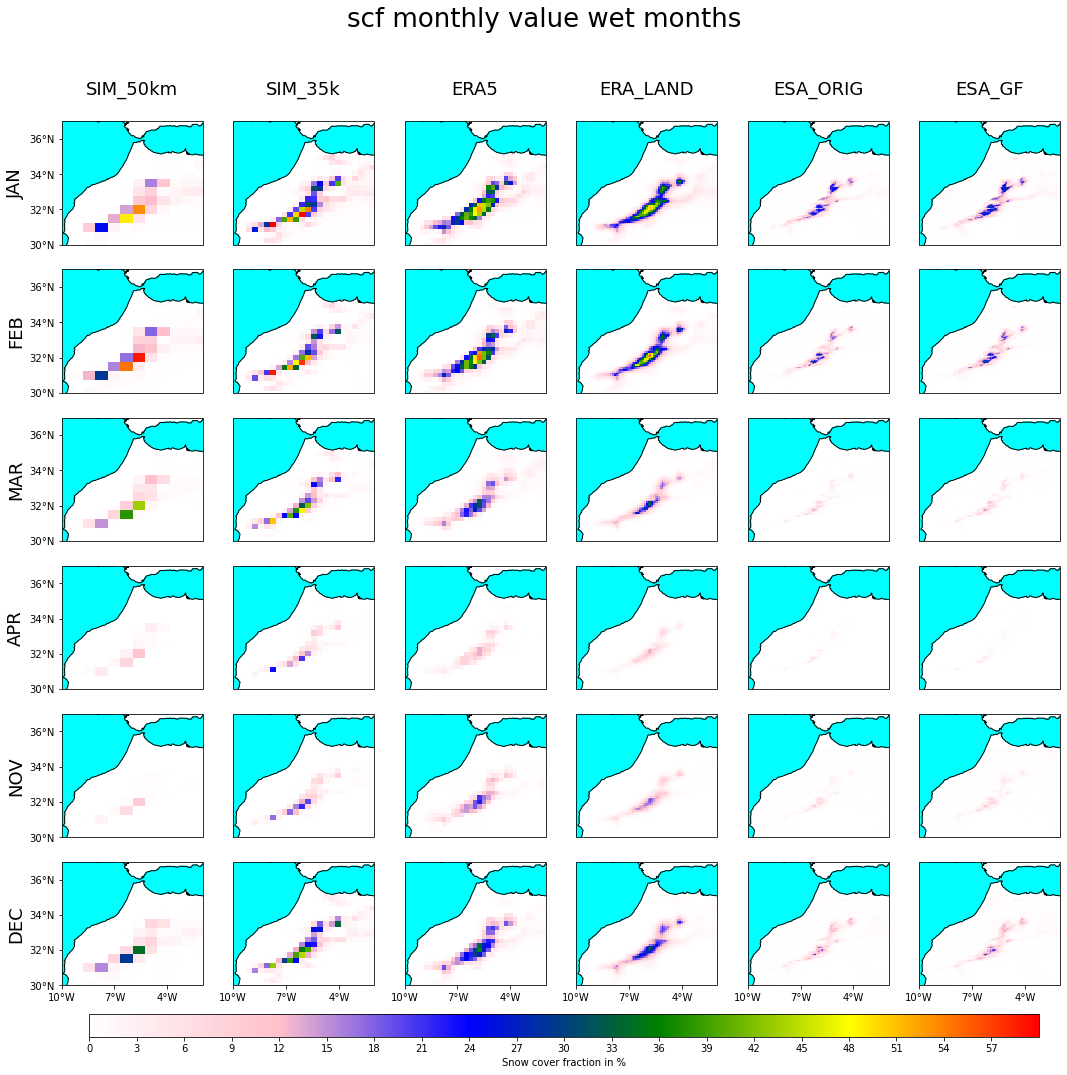

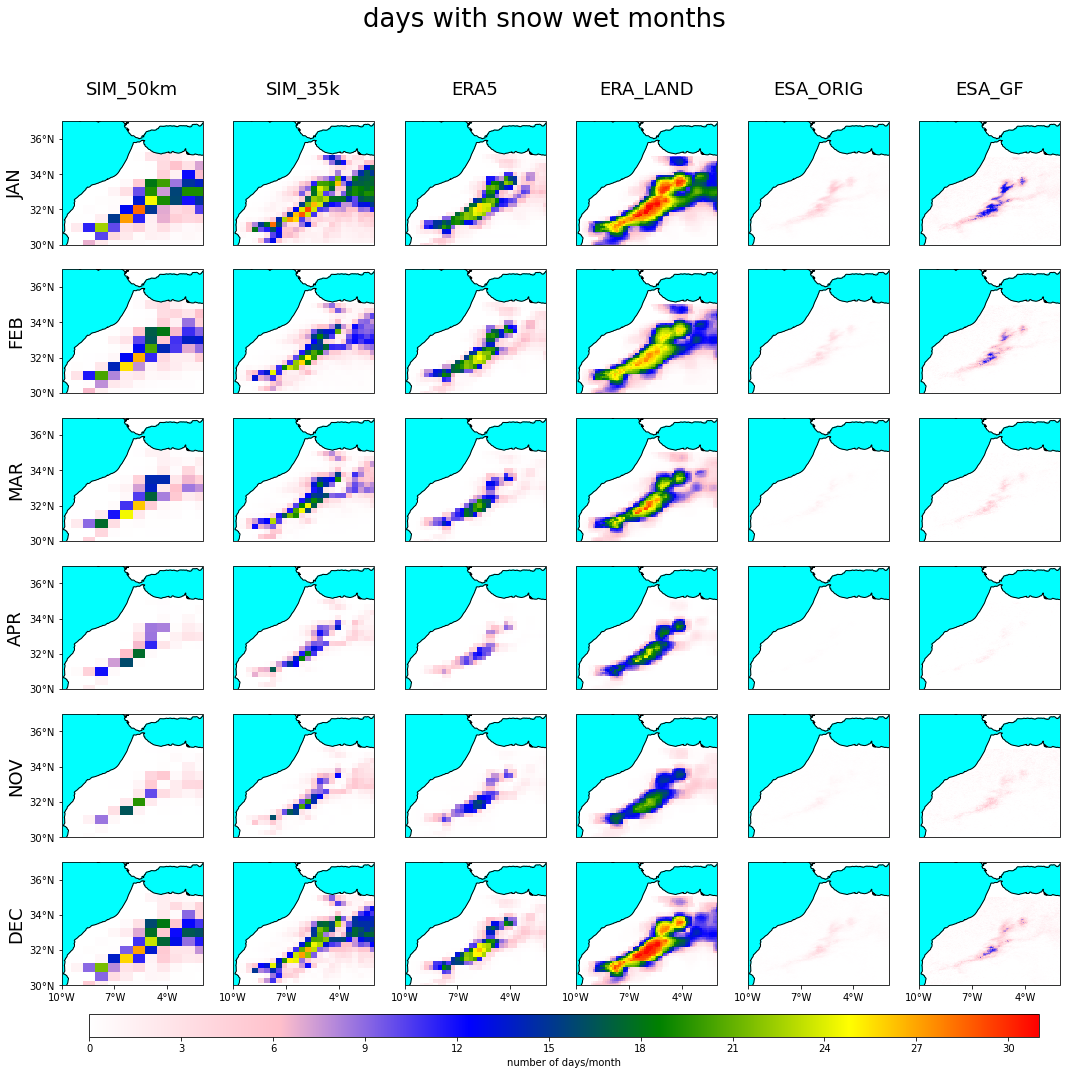

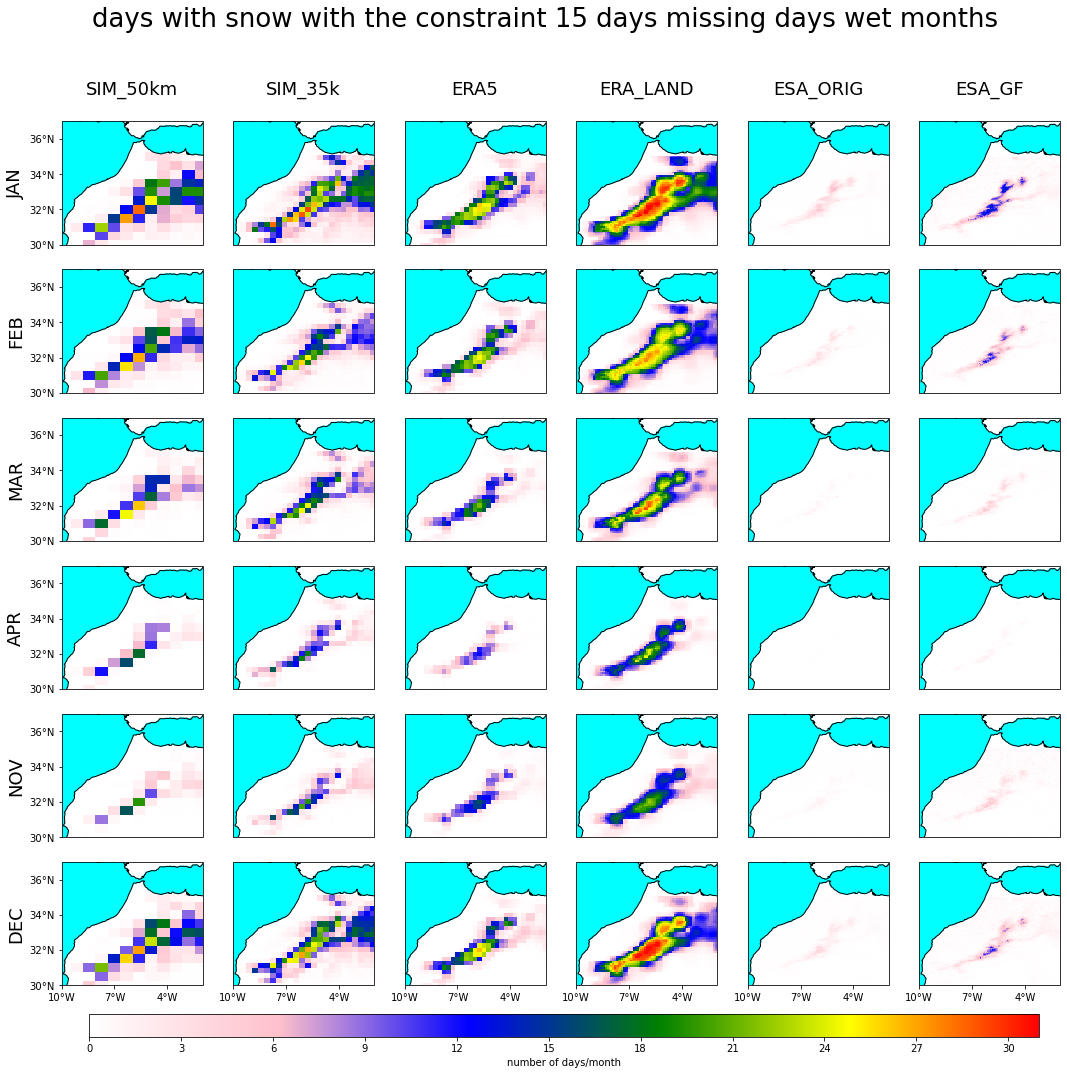

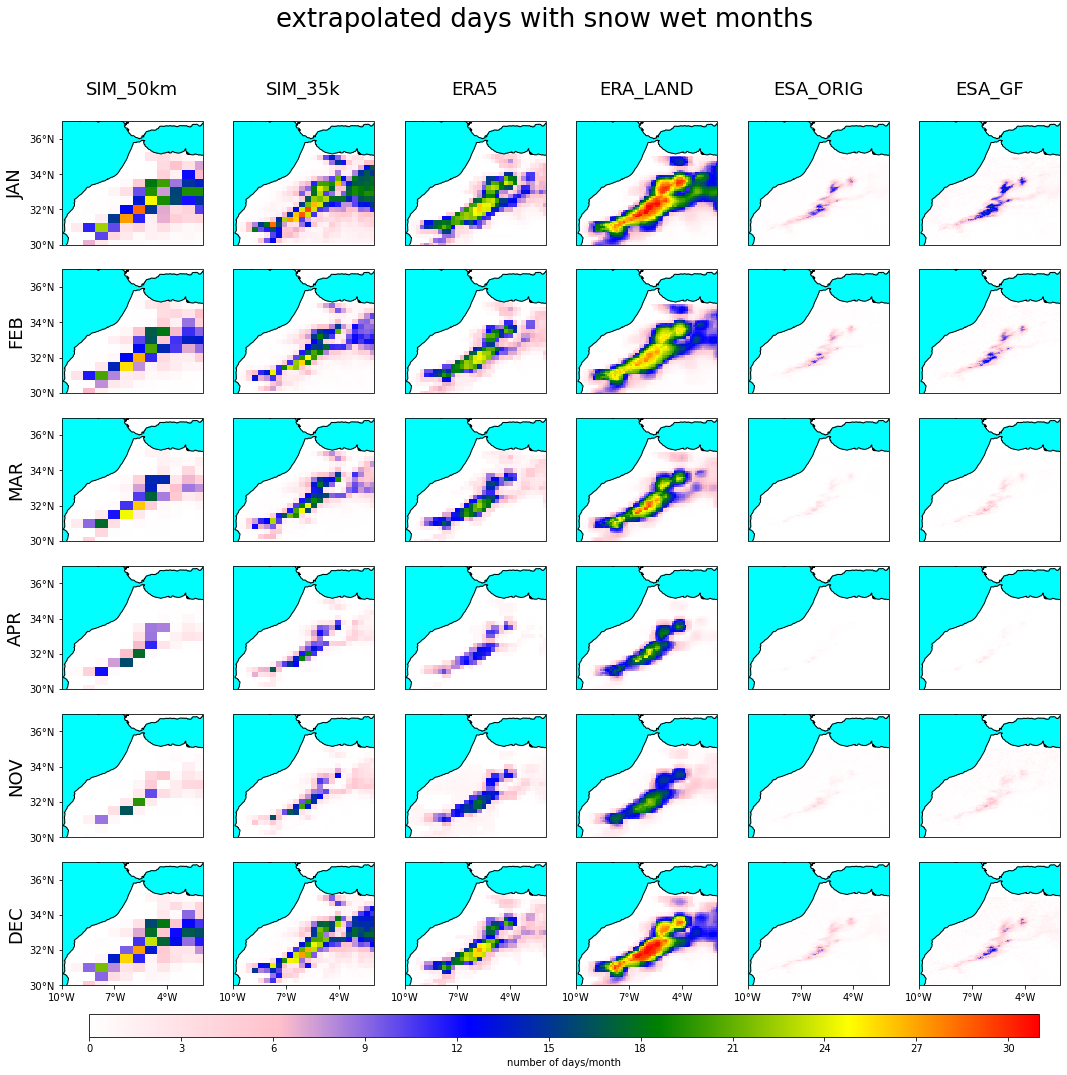

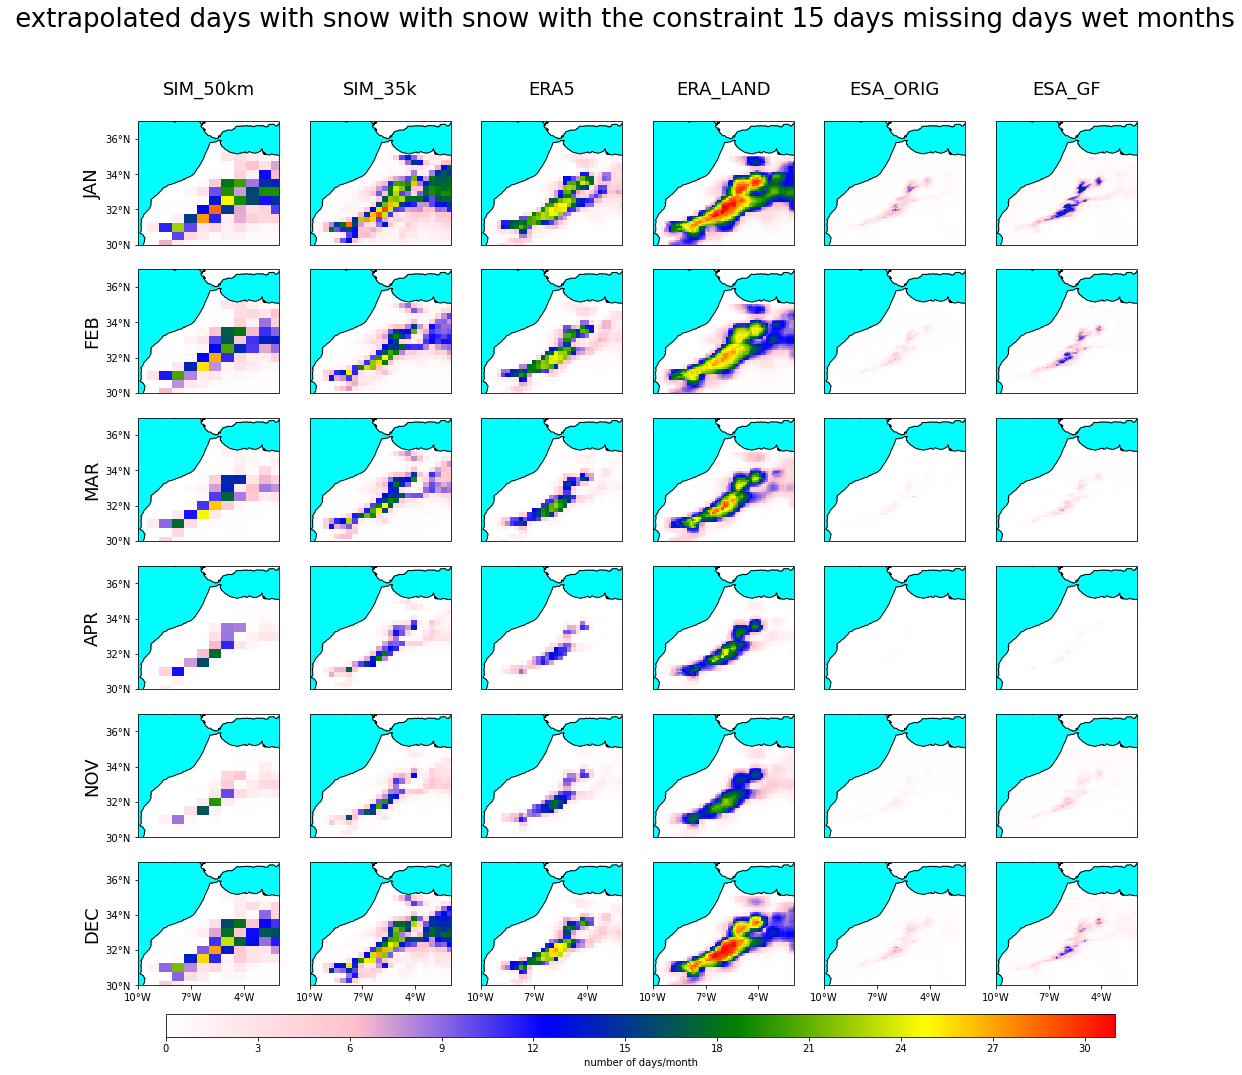

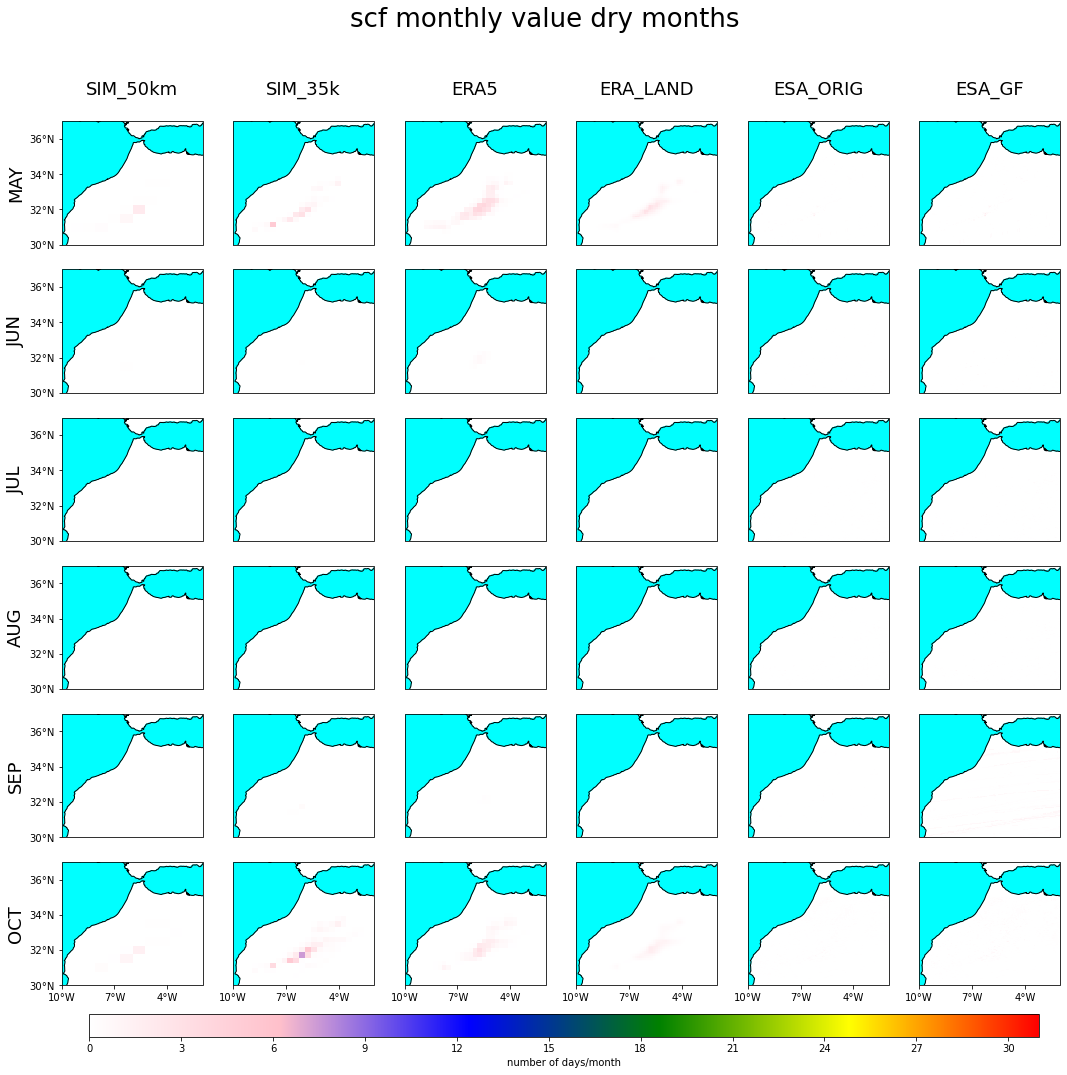

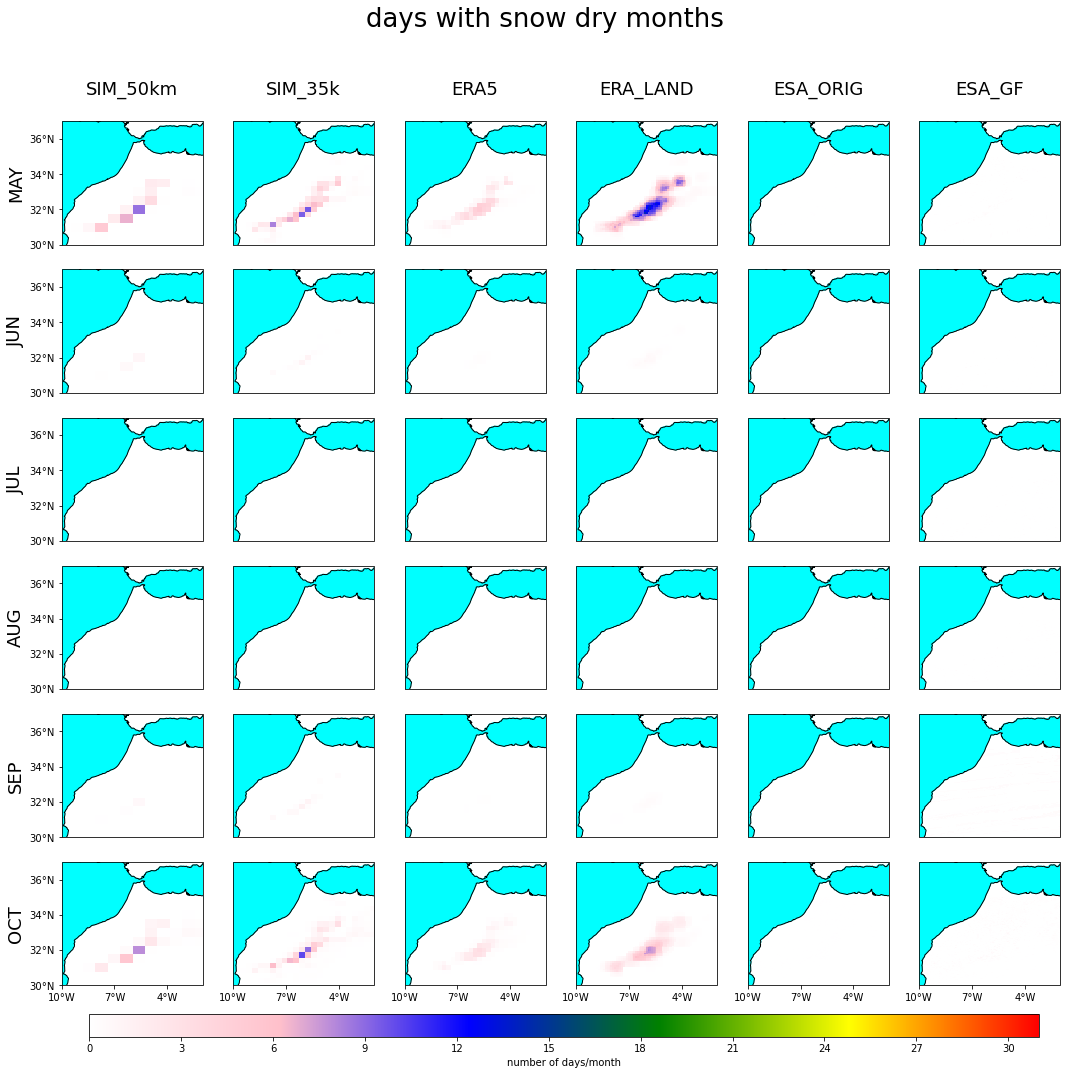

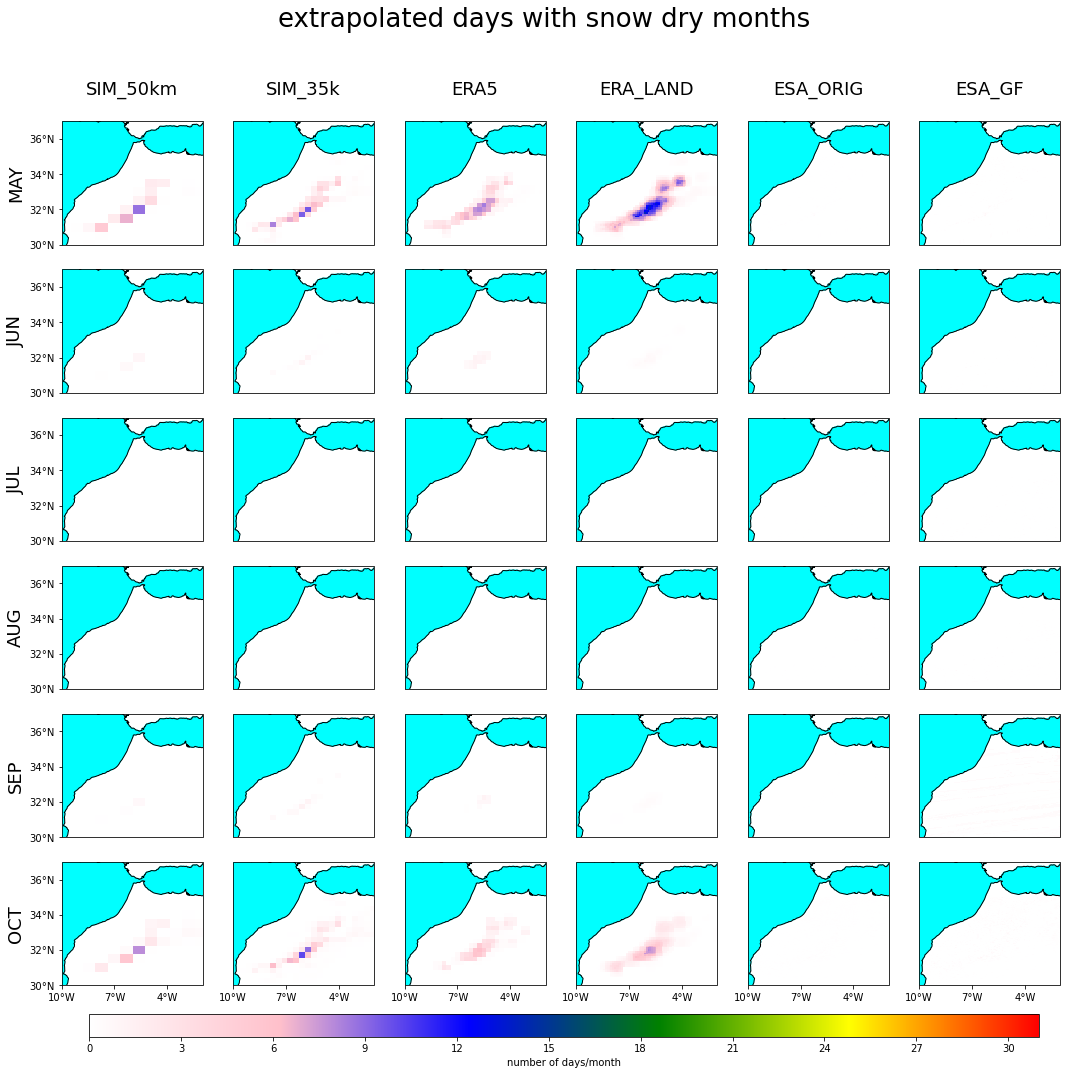

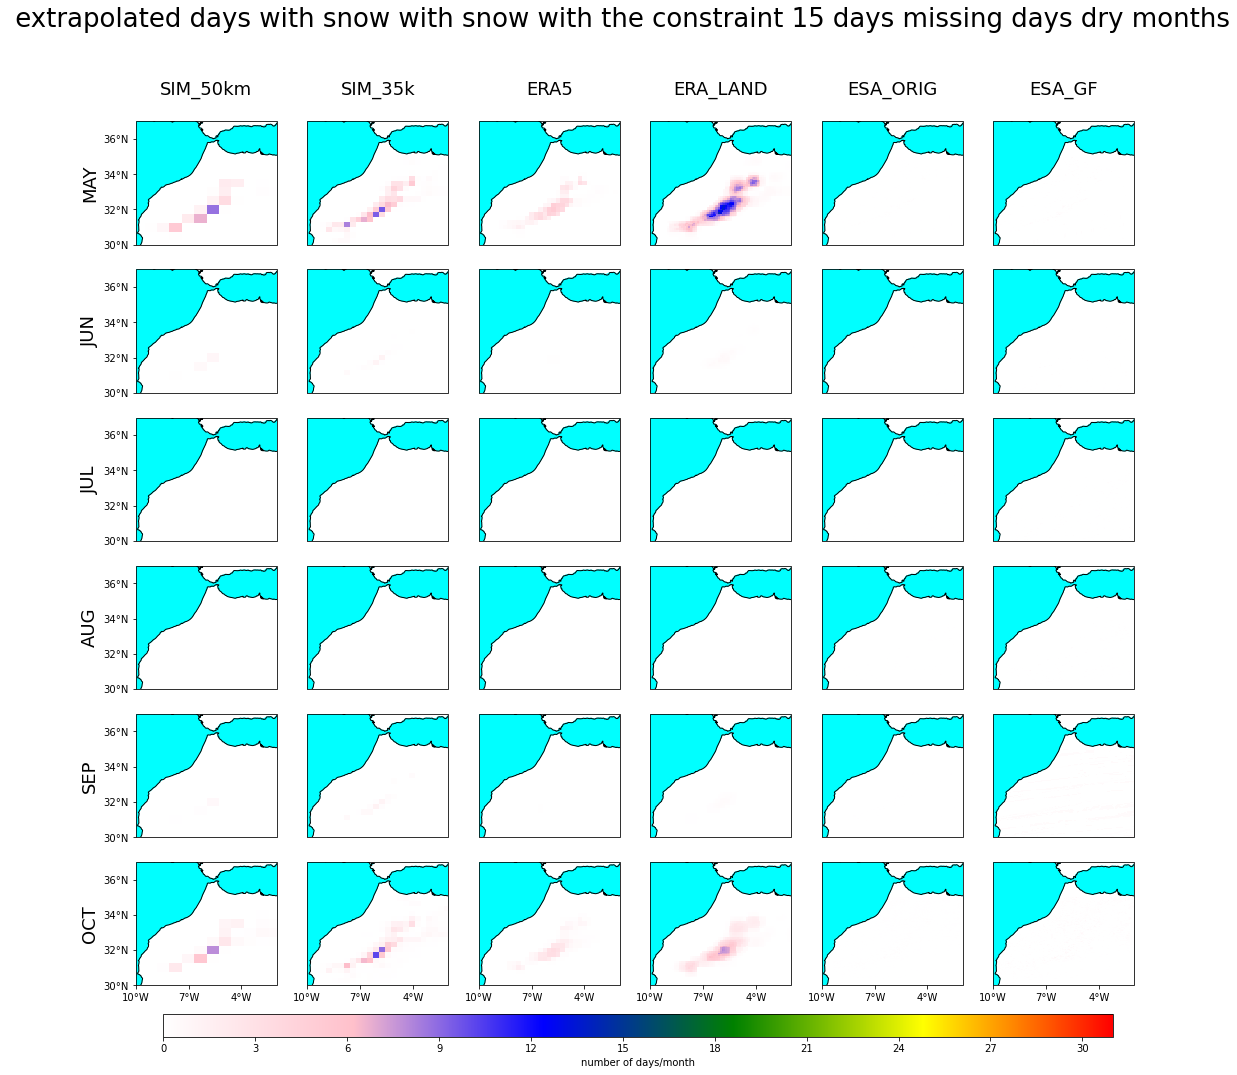

In [17]:
# Define the figure and each axis for the 3 rows and 3 columns
for key_mon in ['wet','dry']:
    for ctr,par in enumerate(parameters):
        if ctr==2:
            scf_max_leg = 31
            scf_min_leg = 0
            leg_title = 'number of days/month'
        fig, axs = plt.subplots(nrows=6,ncols=6,
                        subplot_kw={'projection': ccrs.PlateCarree()}) #   figsize=(11,8.5)
        plt.subplots_adjust(wspace=0.14,hspace=0.2)
        set_size(14,12) 

        # axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
        axs=axs.flatten()

        #Loop over all of the datasets
        i=0 
        j=0
        for mon in months[key_mon]: 
            for key in keys_dic:  
                
                # Select the week 1 forecast from the specified model
                data=monthly_values_basic_mean[key].loc[{'month':mon}][par]
        
                # plot
                cs=data.plot(ax=axs[i], cmap=cmap_init , add_colorbar=False, vmin=scf_min_leg, vmax=scf_max_leg, add_labels=False)
        
                axs[i].add_feature(cf.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor='cyan'))
                axs[i].set_extent([ -10, -2, 30, 37])

                # Draw the coastines for each subplot
                axs[i].coastlines()
     
                i=i+1
            j=j+1    
        k=0
        for i in range(0,31,6):
            axs[i].set_ylabel(months_labels[key_mon][k],  fontsize=18)
            k=k+1
    
        for i in range(6):
            axs[i].set_title(keys_dic[i]+'\n',  fontsize=18)
    

    
        # Longitude labels
        for i in range(30,36):
            axs[i].set_xticks(np.arange(-10,-2,3), crs=ccrs.PlateCarree())
            lon_formatter = LongitudeFormatter()
            axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        for i in [0,6,12,18,24,30]:
            axs[i].set_yticks(np.arange(30,37,2), crs=ccrs.PlateCarree())
            lat_formatter = LatitudeFormatter()
            axs[i].yaxis.set_major_formatter(lat_formatter)
       
        # Add a colorbar axis at the bottom of the graph
        cbar_ax = fig.add_axes([0.15, 0.08, 0.73, 0.02])

        # Draw the colorbar
        fig.colorbar(cs, cax=cbar_ax, cmap=cmap_init , label=leg_title, ticks=[val for val in range(scf_min_leg,scf_max_leg,3)], orientation='horizontal') #  ) # extend='right
        fig.suptitle(suptitles[par]+' '+key_mon+' months', fontsize=26)

In [18]:
scf_max_leg = 60
scf_min_leg = 0

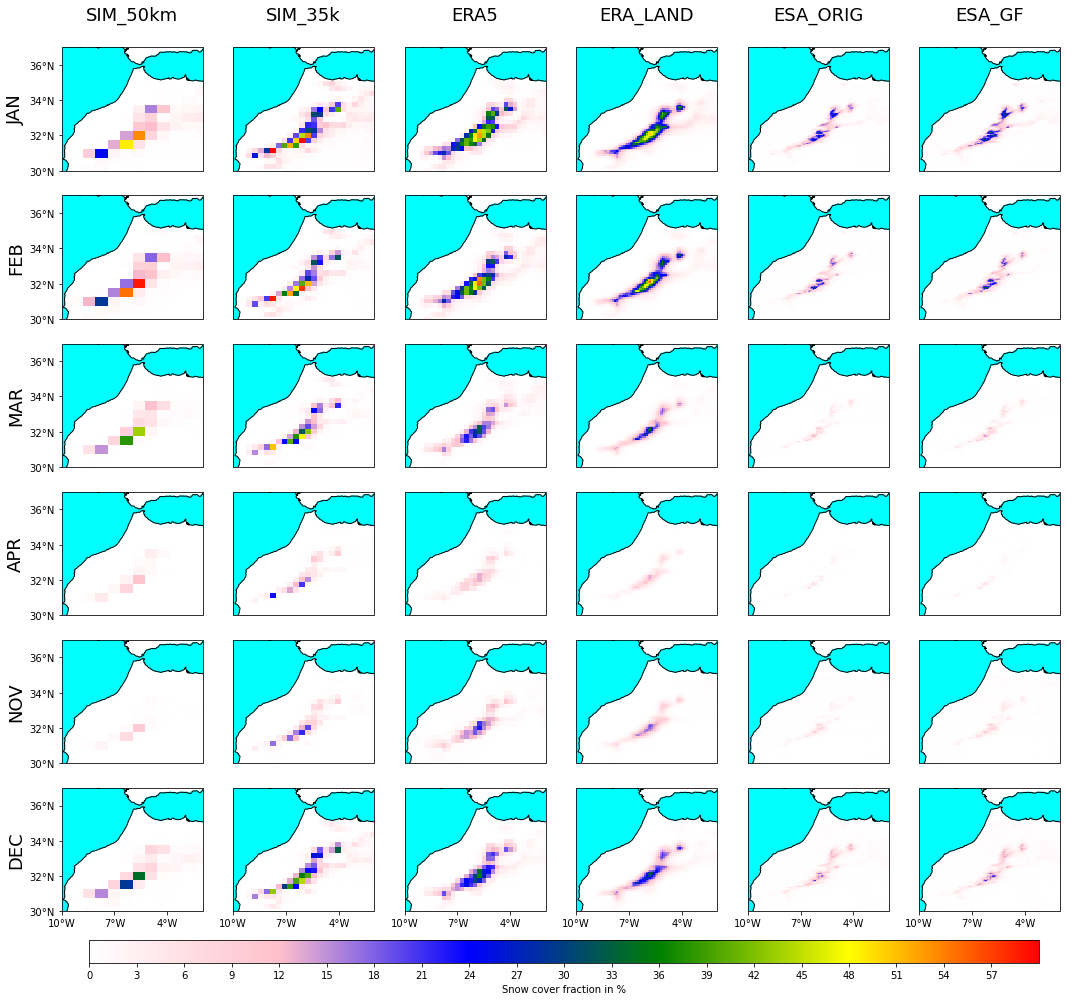

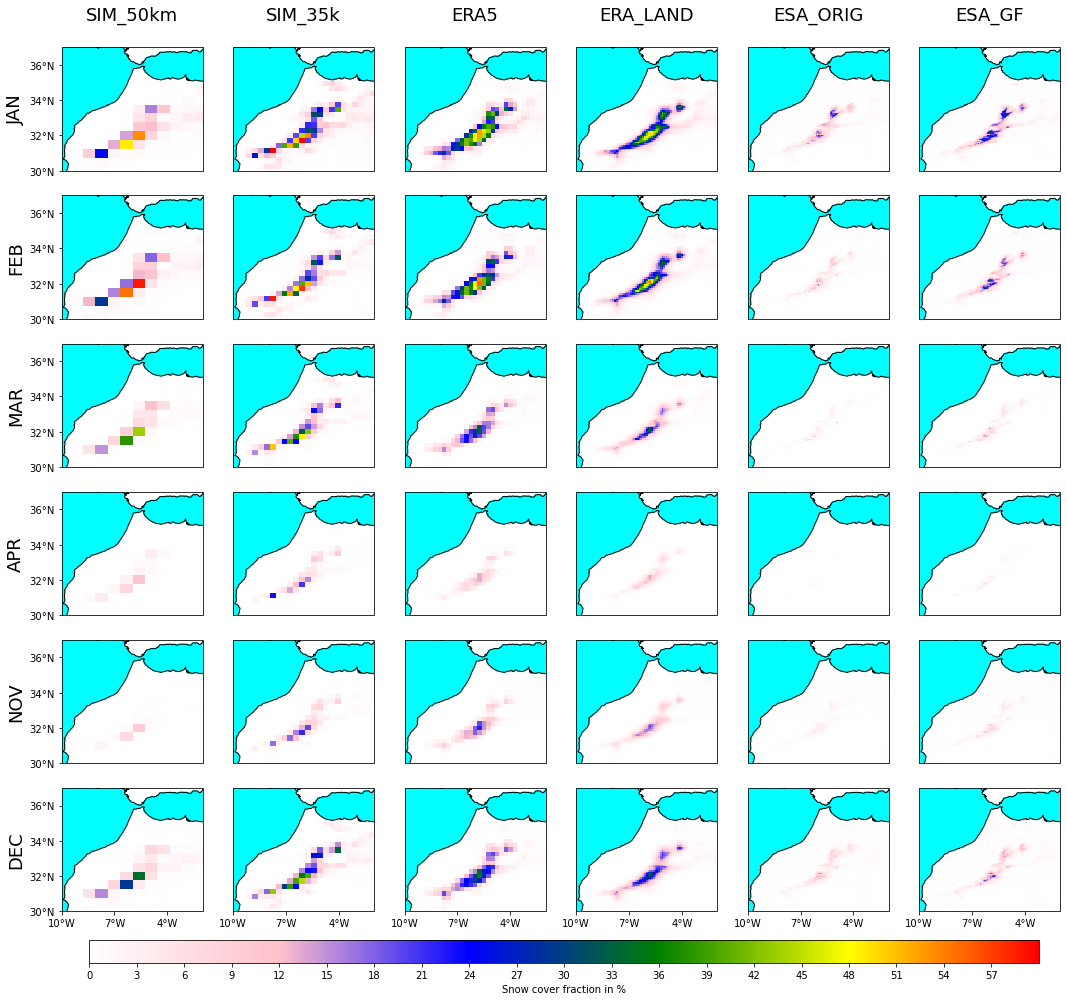

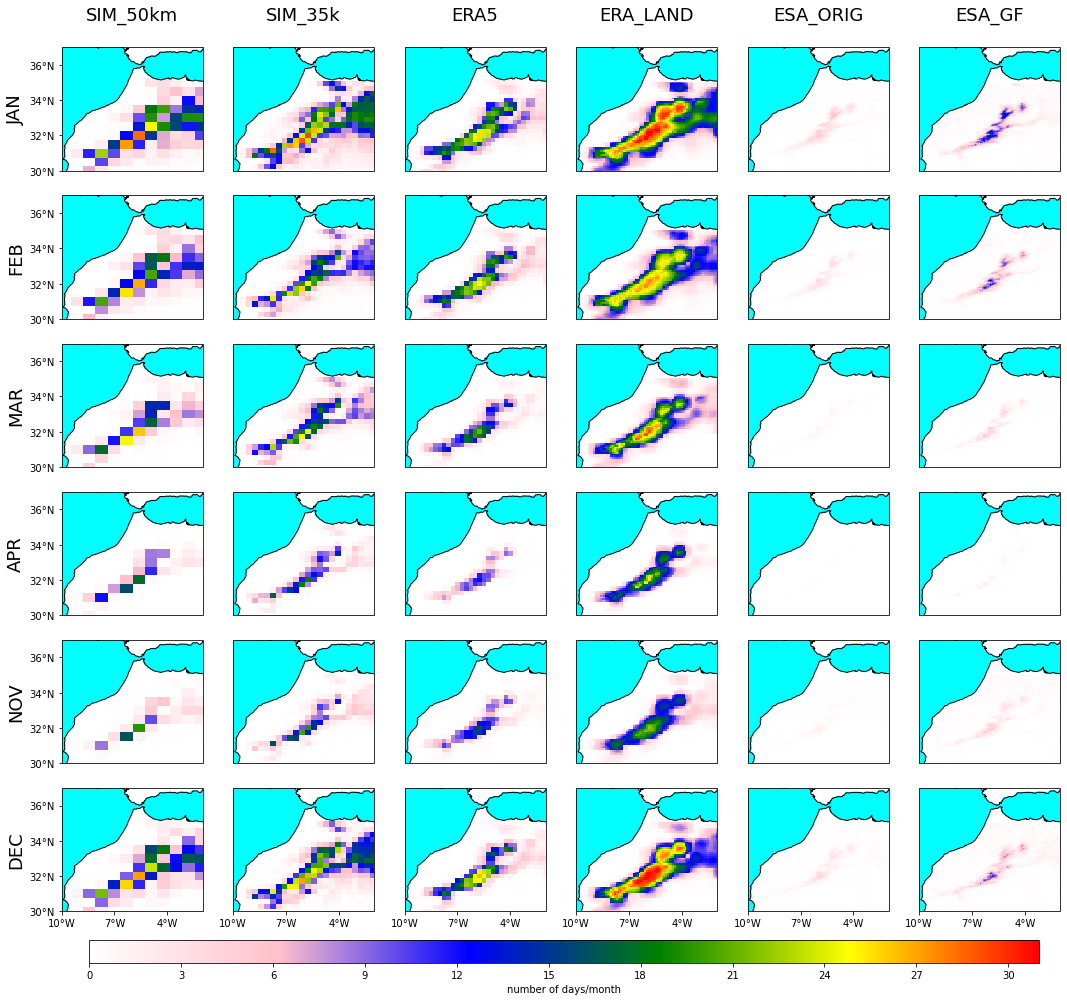

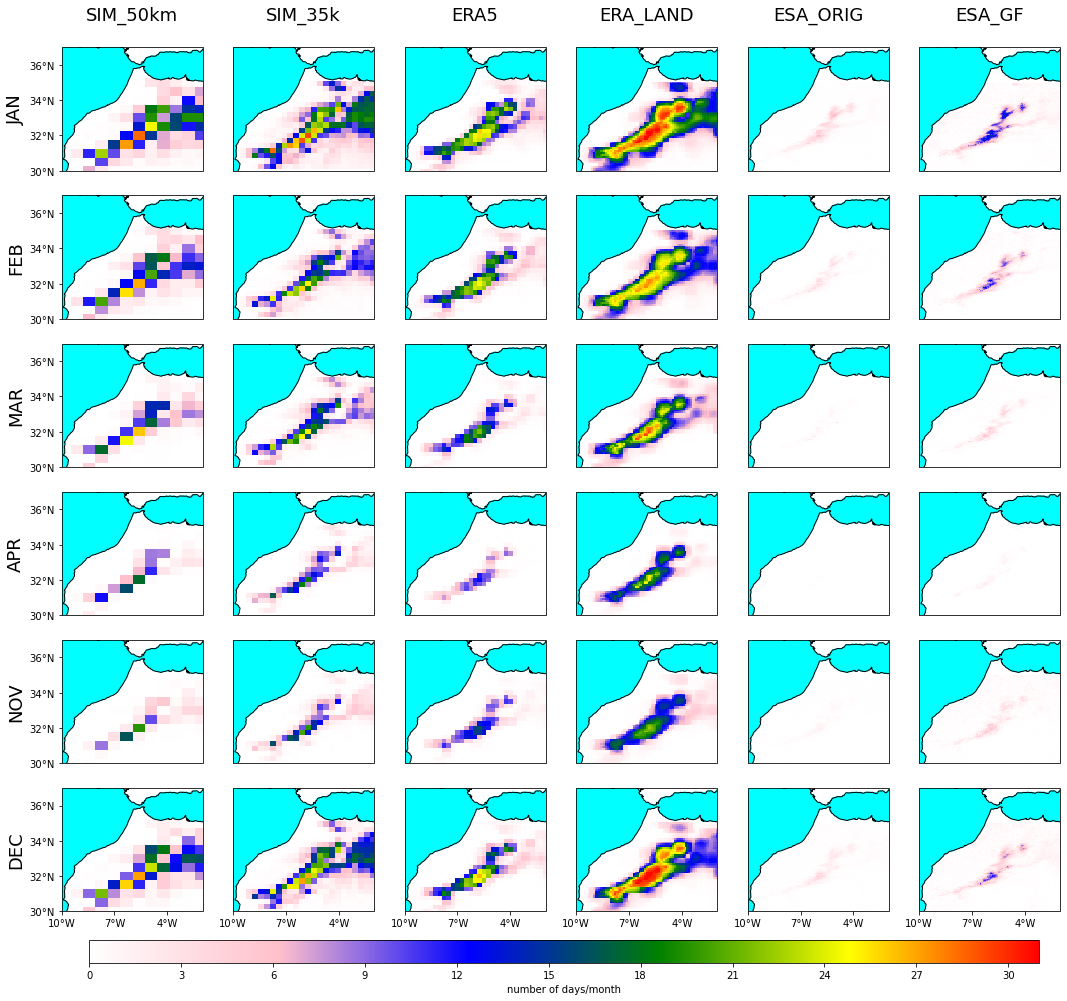

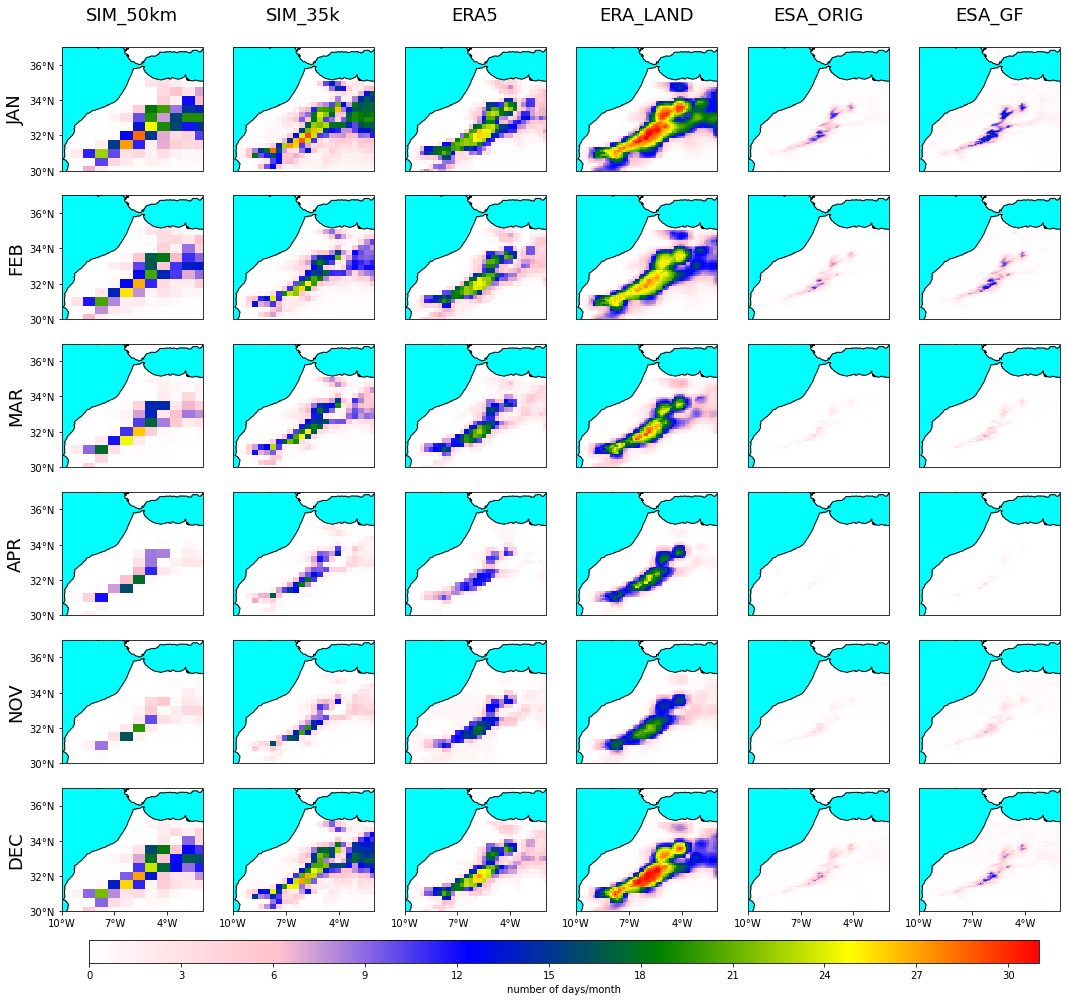

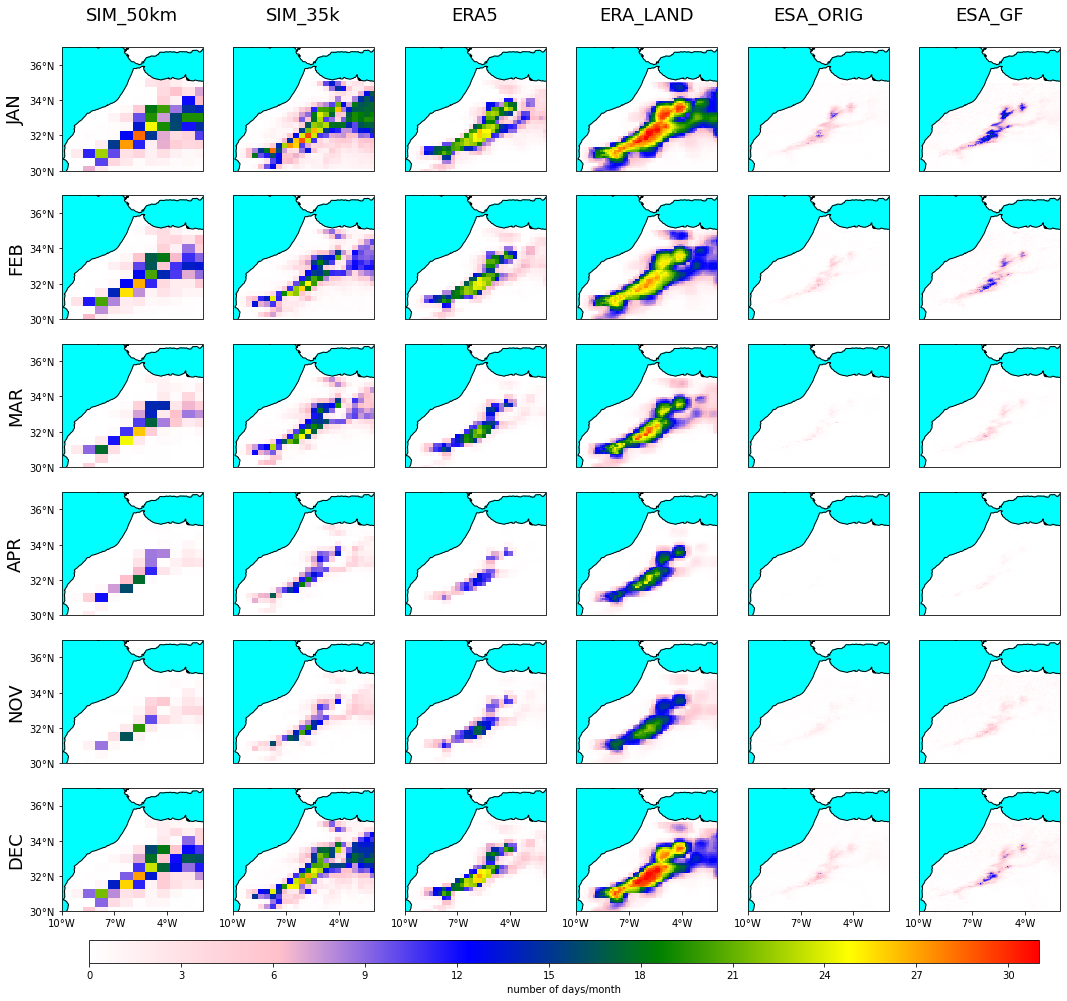

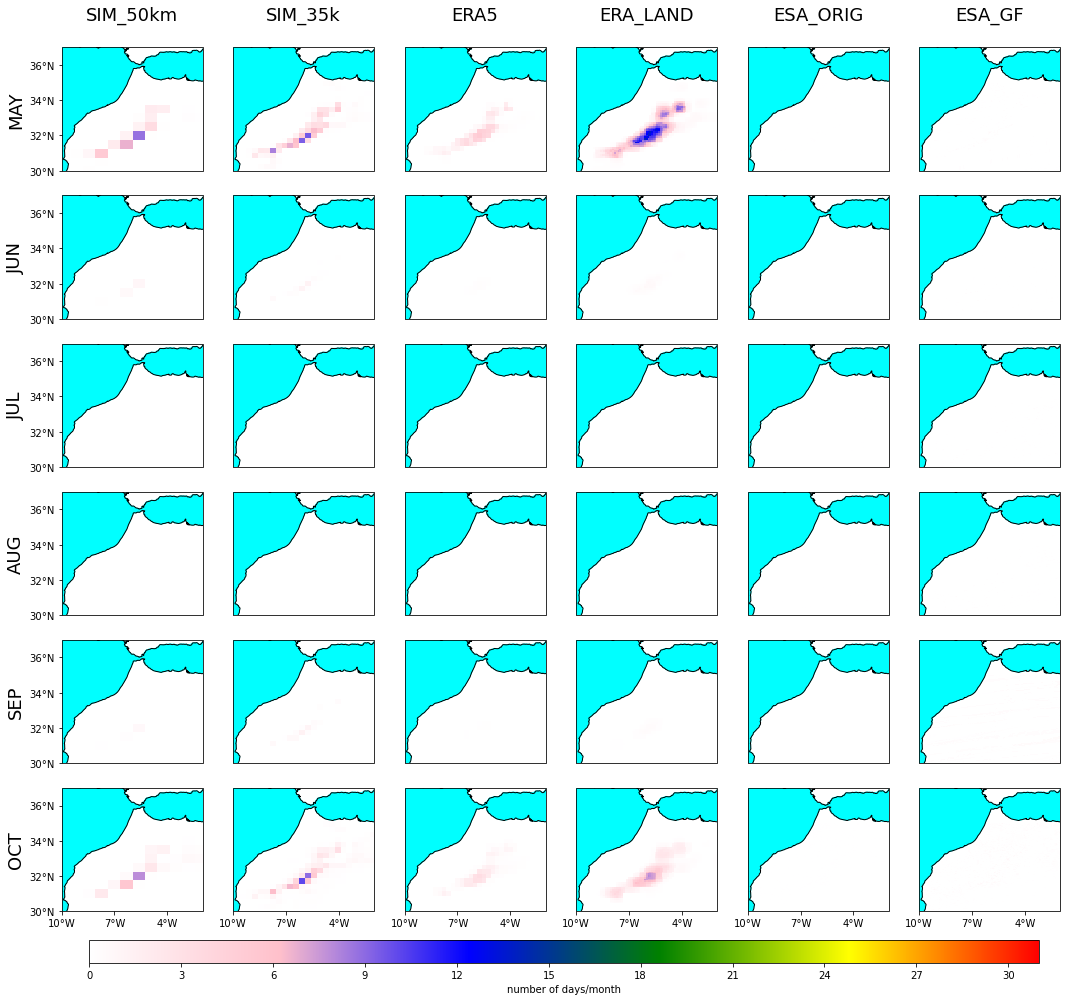

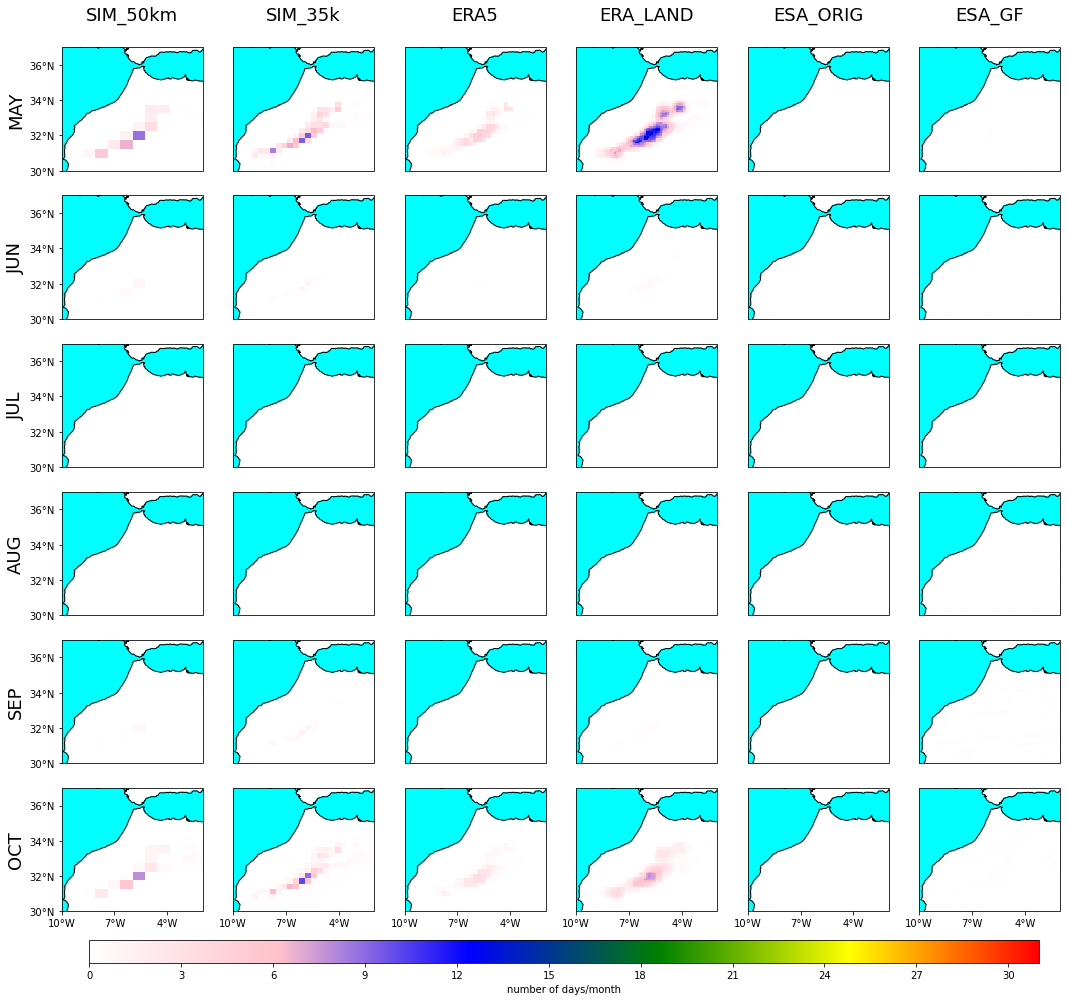

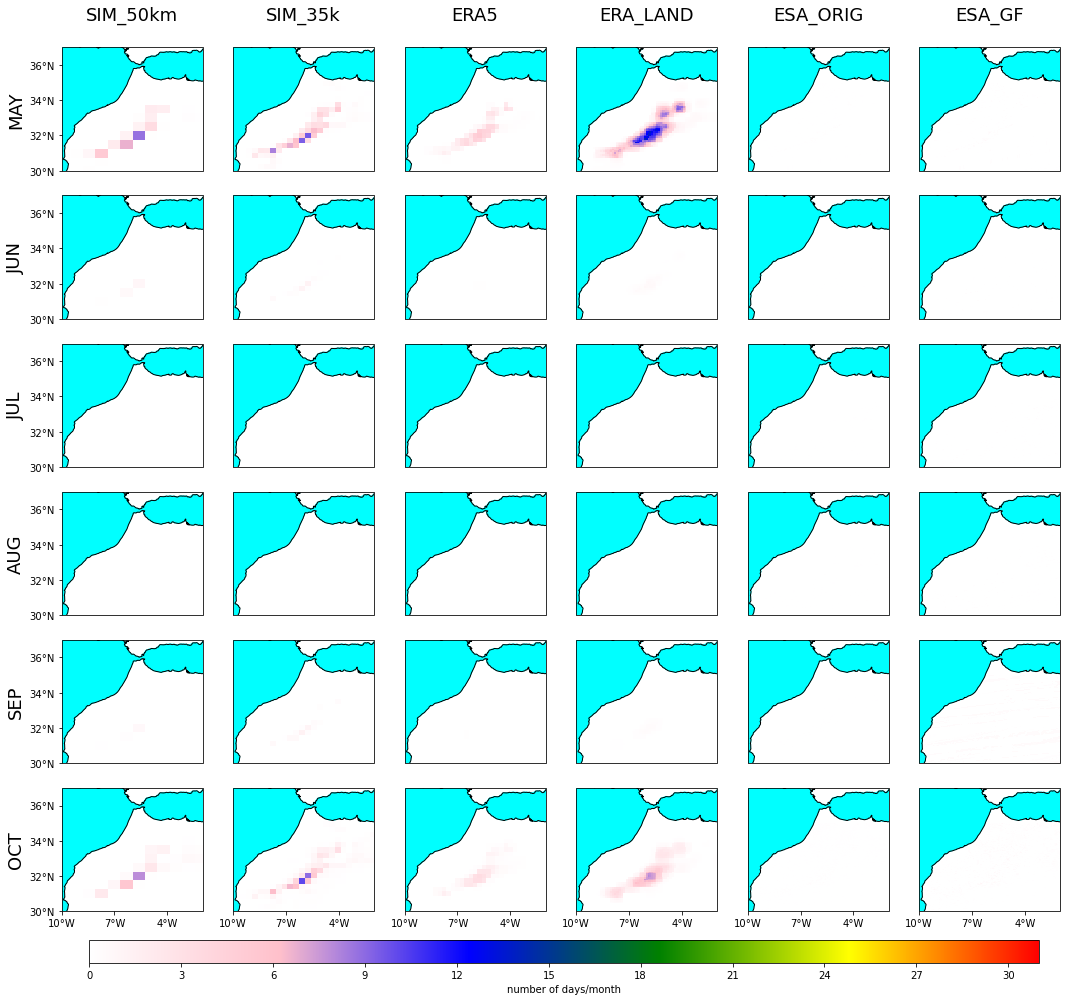

In [20]:
# Define the figure and each axis for the 3 rows and 3 columns
for key_mon in ['wet','dry']:
    for ctr,par in enumerate(parameters):
        if ctr==2:
            scf_max_leg = 31
            scf_min_leg = 0
            leg_title = 'number of days/month'
        fig, axs = plt.subplots(nrows=6,ncols=6,
                        subplot_kw={'projection': ccrs.PlateCarree()}) #   figsize=(11,8.5)
        plt.subplots_adjust(wspace=0.14,hspace=0.2)
        set_size(14,12) 

        # axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
        axs=axs.flatten()

        #Loop over all of the datasets
        i=0 
        j=0
        for mon in months[key_mon]: 
            for key in keys_dic:  
                
                # Select the week 1 forecast from the specified model
                data=monthly_values_basic_mean[key].loc[{'month':mon}][par]
        
                # plot
                cs=data.plot(ax=axs[i], cmap=cmap_init , add_colorbar=False, vmin=scf_min_leg, vmax=scf_max_leg, add_labels=False)
        
                axs[i].add_feature(cf.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor='cyan'))
                axs[i].set_extent([ -10, -2, 30, 37])

                # Draw the coastines for each subplot
                axs[i].coastlines()
     
                i=i+1
            j=j+1    
        k=0
        for i in range(0,31,6):
            axs[i].set_ylabel(months_labels[key_mon][k],  fontsize=18)
            k=k+1
    
        for i in range(6):
            axs[i].set_title(keys_dic[i]+'\n',  fontsize=18)
    

    
        # Longitude labels
        for i in range(30,36):
            axs[i].set_xticks(np.arange(-10,-2,3), crs=ccrs.PlateCarree())
            lon_formatter = LongitudeFormatter()
            axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        for i in [0,6,12,18,24,30]:
            axs[i].set_yticks(np.arange(30,37,2), crs=ccrs.PlateCarree())
            lat_formatter = LatitudeFormatter()
            axs[i].yaxis.set_major_formatter(lat_formatter)
       
        # Add a colorbar axis at the bottom of the graph
        cbar_ax = fig.add_axes([0.15, 0.08, 0.73, 0.02])

        # Draw the colorbar
        fig.colorbar(cs, cax=cbar_ax, cmap=cmap_init , label=leg_title, ticks=[val for val in range(scf_min_leg,scf_max_leg,3)], orientation='horizontal') #  ) # extend='right
        #fig.suptitle(suptitles[par]+' '+key_mon+' months', fontsize=26)
        
        # Store the figure in pdf file 
        plt.savefig(output_path_figures+'/'+par+'_'+key_mon+'_months_average_with_ERA5.pdf')